# PREDICT ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a CNN to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

[Associated lecture slides HERE](https://docs.google.com/presentation/d/1T25rb4giQrOz7VFwf1zu1YzbhC1oVzdRESt8JABrvyk/edit?usp=sharing)

### Load Libraries

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import time as time_lib

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

import keras
import tensorflow as tf

sys.path.append('/glade/work/kjmayer/ML_demos/EdEc_ML/utils/')
from ENSO_utils import get_data, get_nino34, plot_nino34, get_nino34events, split_data, standardize_data, make_cat, plot_input, plot_inputvector, plot_datasplit, plot_datasplitcat

# set seeds
random_seed = 36
np.random.seed(random_seed)
keras.utils.set_random_seed(int(random_seed))

2025-09-04 09:50:58.994363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 09:50:59.032242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 09:51:03.558421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# CREATE CNN FUNCTION (CATEGORICAL)

In [2]:
## >>>>> create neural network architecture >>>>>
def defineCNN(filters, kernel_size, dense, input_shape, output_shape, ridge_penalty=0., lasso_penalty=0., act_fun='relu', network_seed=99):

    inputs = keras.Input(shape = input_shape)
    x = keras.layers.Conv2D(filters[0],
                            kernel_size[0],
                            data_format = 'channels_first',
                            strides = (1,1),
                            padding = "valid",
                            activation = act_fun,
                            use_bias = True,
                            kernel_regularizer = keras.regularizers.l1_l2(l1=lasso_penalty, l2=ridge_penalty),
                            bias_initializer= keras.initializers.RandomNormal(seed=network_seed),
                            kernel_initializer= keras.initializers.RandomNormal(seed=network_seed)
                           )(inputs)

    #initialize hidden layers
    for ilayer in range(len(filters))[1:]:
        x = keras.layers.MaxPooling2D((2, 2))(x)
        x = keras.layers.Conv2D(filters[ilayer],
                                kernel_size[ilayer], 
                                data_format = 'channels_first',
                                strides = (1,1),
                                activation = act_fun,
                                use_bias = True,
                                kernel_regularizer = keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                bias_initializer = keras.initializers.RandomNormal(seed=network_seed),
                                kernel_initializer = keras.initializers.RandomNormal(seed=network_seed)
                               )(x)

    x = keras.layers.Flatten()(x)

    for idenselayer in range(len(dense)):
        x = keras.layers.Dense(dense[idenselayer],
                               activation = act_fun,
                               use_bias = True,
                               kernel_regularizer = keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                               bias_initializer = keras.initializers.RandomNormal(seed=network_seed),
                               kernel_initializer = keras.initializers.RandomNormal(seed=network_seed)
                              )(x)
    
    #initialize output layer
    output_layer = keras.layers.Dense(output_shape,
                                      activation = 'softmax', # ONLY CHANGE FROM REGRESSION
                                      use_bias = True,
                                      kernel_regularizer = keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = keras.initializers.RandomNormal(seed=network_seed),
                                      kernel_initializer = keras.initializers.RandomNormal(seed=network_seed)
                                     )(x)

    #create model
    model = keras.Model(inputs=inputs, outputs=output_layer)

    return model

## GET & PREP DATA
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

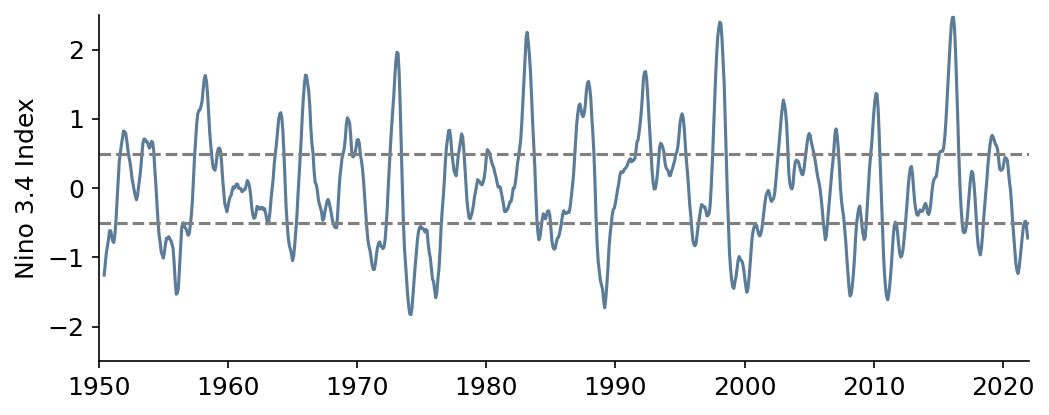

In [3]:
sst_all = get_data(download=False)

# Preprocess ANN Input Data:
sst = sst_all.where((sst_all.lat <= 30) & (sst_all.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sst.time

# Preprocess ANN Output Data:
nino34 = get_nino34(sst)
plot_nino34(nino34)

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [4]:
# Grab only El Nino and La Nina samples from input & output
enso_magnitude = 0.5
sst = np.asarray(sst)
x,y = get_nino34events(sst, nino34, enso_magnitude, vectorize=False)

# Split data:
num_samples = y.shape[0]
train_val_test = [0.7,0.85,1] # set train/val/test fraction (must be increasing)

xtrain, xval, xtest, ytrain, yval, ytest, trainind, valind, testind = split_data(num_samples,
                                                                                 train_val_test,
                                                                                 x,
                                                                                 y)

# standardized by the TRAINING STD
xtrain, xval, xtest = standardize_data(xtrain,
                                       xval,
                                       xtest)

# add channel dimension (required for cnn input)
xtrain = np.expand_dims(xtrain, axis=1)
xval = np.expand_dims(xval, axis=1)
xtest = np.expand_dims(xtest, axis=1)

#set all nans to zeros (the NN should learn to ignore them)
xtrain[np.isnan(xtrain)] = 0
xval[np.isnan(xval)] = 0
xtest[np.isnan(xtest)] = 0

# make into categorical format, 1 for El Nino and 0 for La Nina
ytrain = keras.utils.to_categorical(make_cat(ytrain, enso_magnitude))
yval = keras.utils.to_categorical(make_cat(yval, enso_magnitude))
ytest = keras.utils.to_categorical(make_cat(ytest, enso_magnitude))

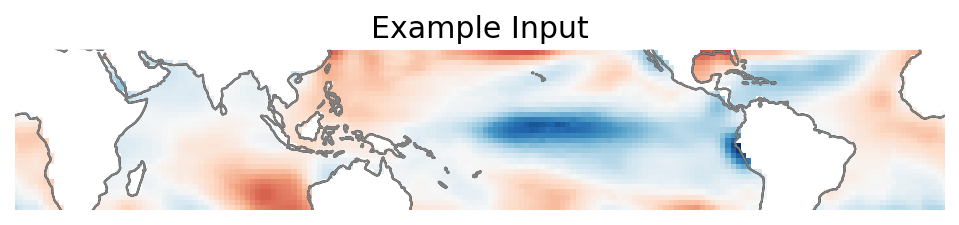

In [5]:
# Print input sample
plot_input(sst[0],lon,lat)

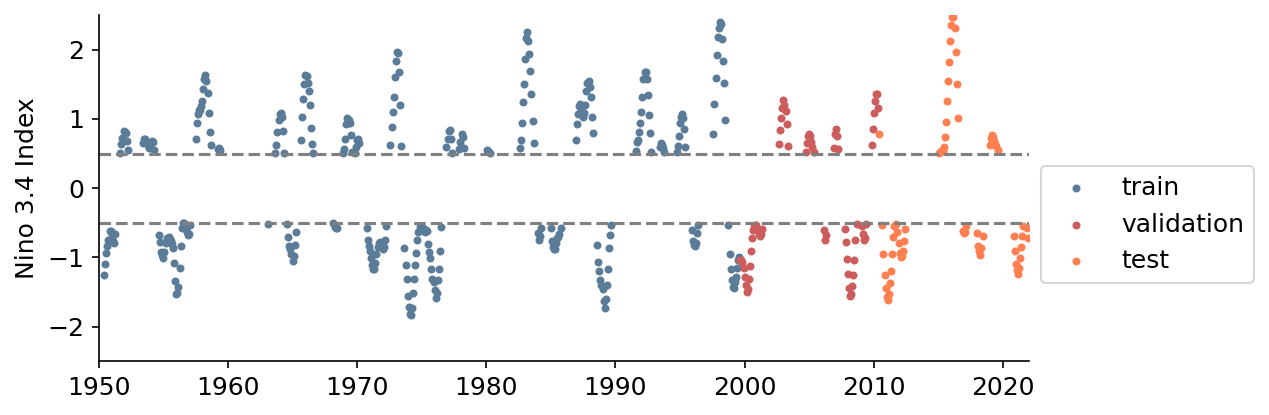

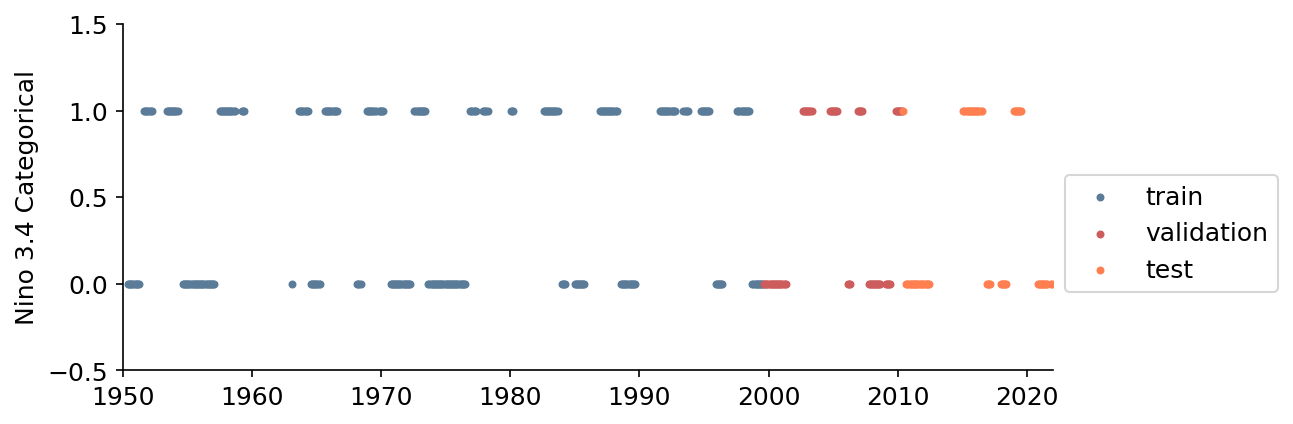

In [6]:
plot_datasplit(nino34,
               enso_magnitude,
               trainind,valind,testind)
plot_datasplitcat(np.argmax(ytrain,axis=1),
                  np.argmax(yval,axis=1),
                  np.argmax(ytest,axis=1),
                  nino34,
                  enso_magnitude,
                  trainind,valind,testind)

# TIME TO TRAIN

In [21]:
################################################################################
# set training parameters
FILTERS = [4]
KERNEL_SIZE = [[2,2]]
HIDDEN_LAYERS = [4] # number of nodes per hidden layer 
RIDGE_PEN = 0 # L2/ridge penalty applied to input
LR = 0.1 # learning rate
N_EPOCHS = 20 # number training epochs
BATCH_SIZE = 32
ACT_FUNC = 'relu'

OPTIMIZER = 'adam'
LOSS_FUNC = 'categorical_crossentropy' 
################################################################################

In [31]:
# ------ define NN ------
cnn = defineCNN(FILTERS,
                KERNEL_SIZE,
                HIDDEN_LAYERS,
                input_shape=xtrain[0].shape,
                output_shape=2, # number of categories
                act_fun=ACT_FUNC,
                ridge_penalty=RIDGE_PEN,
               )

# ------ Training Hyperparameters ------
if OPTIMIZER == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate = LR)
elif OPTIMIZER == 'SGD':
    optimizer = keras.optimizers.SGD(learning_rate = LR, momentum = 0.99)

metrics = [keras.metrics.categorical_accuracy]
    
# ------ Compile Model -----
cnn.compile(optimizer=optimizer,
            loss=LOSS_FUNC,
            metrics=metrics) 

# ------ Train -----
start_time = time_lib.time()
history = cnn.fit(xtrain, ytrain,
                  validation_data=[xval, yval],
                  epochs=N_EPOCHS,
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  verbose=2)
stop_time = time_lib.time()
print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

cnn.summary()

Epoch 1/20
11/11 - 1s - 64ms/step - categorical_accuracy: 0.8210 - loss: 0.3759 - val_categorical_accuracy: 0.9429 - val_loss: 0.2054
Epoch 2/20
11/11 - 0s - 16ms/step - categorical_accuracy: 0.9815 - loss: 0.0853 - val_categorical_accuracy: 1.0000 - val_loss: 0.0382
Epoch 3/20
11/11 - 0s - 13ms/step - categorical_accuracy: 0.9938 - loss: 0.0396 - val_categorical_accuracy: 1.0000 - val_loss: 0.0129
Epoch 4/20
11/11 - 0s - 12ms/step - categorical_accuracy: 1.0000 - loss: 0.0168 - val_categorical_accuracy: 1.0000 - val_loss: 0.0119
Epoch 5/20
11/11 - 0s - 15ms/step - categorical_accuracy: 1.0000 - loss: 0.0132 - val_categorical_accuracy: 1.0000 - val_loss: 0.0175
Epoch 6/20
11/11 - 0s - 11ms/step - categorical_accuracy: 1.0000 - loss: 0.0092 - val_categorical_accuracy: 1.0000 - val_loss: 0.0078
Epoch 7/20
11/11 - 0s - 13ms/step - categorical_accuracy: 1.0000 - loss: 0.0063 - val_categorical_accuracy: 1.0000 - val_loss: 0.0053
Epoch 8/20
11/11 - 0s - 12ms/step - categorical_accuracy: 1.00

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 31, 180)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 30, 179)     │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 21480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │        85,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,864 (1007.29 KB)

 Trainable params: 85,954 (335.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 171,910 (671.53 KB)

# LETS TAKE A LOOK

!!! NEED TO MAKE A FUNCTION FOR PLOTTING !!!

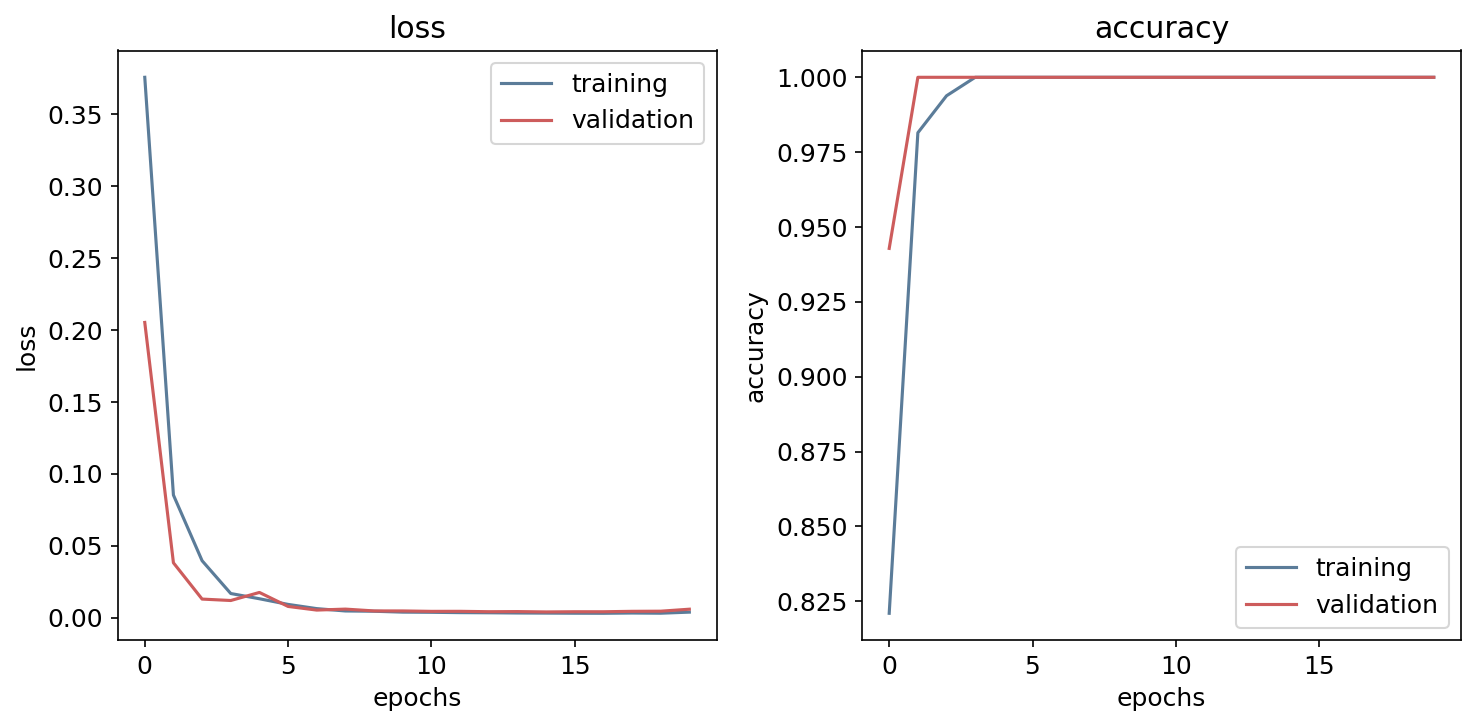

In [32]:
#---------- plot loss -------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_loss'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()

## EVALUATE CNN
How does the model do on unseen data?

In [33]:
ypred = cnn.predict(xtest) # make predictions for test data

ypred = np.argmax(ypred,axis=1)
ytrue = np.argmax(ytest,axis=1)

modelcorr = ypred==ytrue
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = ytrue.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Model accuracy on testing is 100.000000%


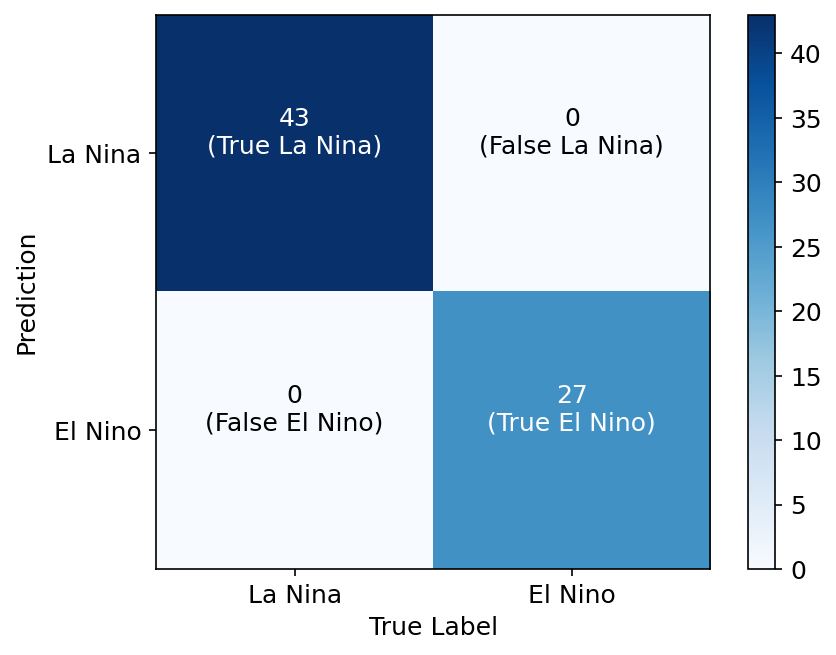

In [34]:
# confusion matrix
cm = tf.math.confusion_matrix(ytrue, ypred).numpy()
plt.imshow(cm, cmap = "Blues")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"]);

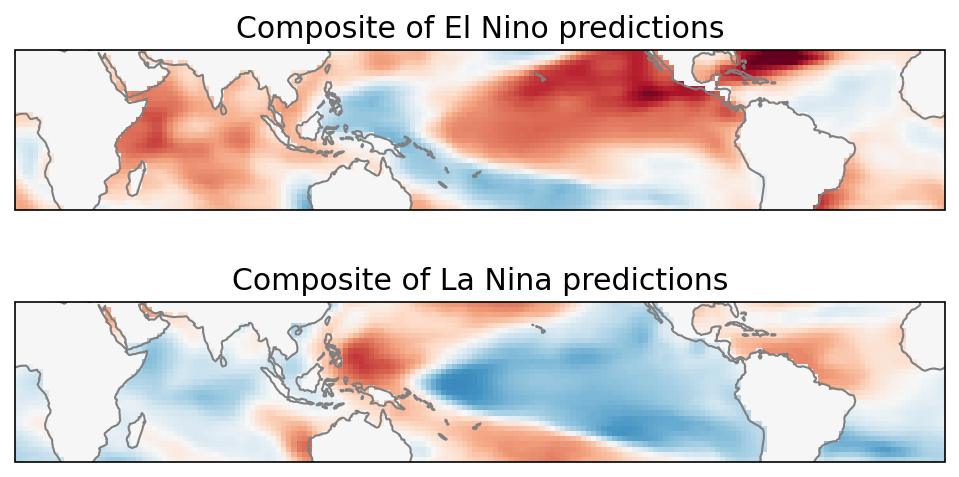

In [35]:
ninopred = (ypred==1)
ninapred = (ypred==0)

nino_sst = np.squeeze(xtest[ninopred,:])
nina_sst = np.squeeze(xtest[ninapred,:])

ninoplot = np.mean(nino_sst,axis=0)
ninaplot = np.mean(nina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,ninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,ninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Are you happy with the model? Go ahead and save it.

In [37]:
cnn.save('saved_model/ENSOmodel_CNN.keras')

## A SOLUTION: DO NOT LOOK

In [30]:
################################################################################
# set training parameters
FILTERS = [4]
KERNEL_SIZE = [[2,2]]
HIDDEN_LAYERS = [4] # number of nodes per hidden layer 
RIDGE_PEN = 1 # L2/ridge penalty applied to input
LR = 0.01 # learning rate
N_EPOCHS = 20 # number training epochs
BATCH_SIZE = 32
ACT_FUNC = 'relu'

OPTIMIZER = 'adam'
LOSS_FUNC = 'categorical_crossentropy' 
################################################################################